In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
############################
## GENERATE ENSEMBLE DATA ##
############################

def generate_ensemble_data(N, Tmkp, alpha, sigma_v, w):
    K = len(Tmkp) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    # Define variables -- with NaN value at n = 0
    T = {player: [np.nan] for player in players}
    t = {player: [np.nan] for player in players}
    A = {pair: [np.nan] for pair in pairs}

    # Initialise values at n = 1
    for player in players:
        T[player].append(0)
        t[player].append(np.random.normal(loc = 0, scale = sigma_v[player]))
    
    for pair in pairs:
        A[pair].append(t[pair[0]][1] - t[pair[1]][1])

    # Simulate onsets
    for n in range(2, N + 1):
        for player in players:
            T[player].append(T[player][n - 1] + Tmkp[player][n])
            
            aux = 0
            for player2 in players:
                if player2 != player:
                    aux += alpha[player + player2][n] * A[player + player2][n - 1]
            t[player].append(t[player][n - 1] + Tmkp[player][n] - aux + np.random.normal(loc = 0, scale = sigma_v[player]))
        
        for pair in pairs:
            A[pair].append(t[pair[0]][n] - t[pair[1]][n])

    # Convert to numpy array
    T = {player: np.array(T[player]) for player in players}
    t = {player: np.array(t[player]) for player in players}
    A = {pair: np.array(A[pair]) for pair in pairs}

    # Compute r and s - NaN for n = 0 and n = 1
    r = {player: 2*[np.nan] for player in players}
    s_true = {player: 2*[np.nan] for player in players}
    s_win = {player: 2*[np.nan] for player in players}

    for n in range (2, N + 1):
        for player in players:
            r[player].append(t[player][n] - t[player][n - 1])
            s_true[player].append(r[player][n] - Tmkp[player][n])
            if n <= w:
                s_win[player].append(r[player][n] - np.mean(r[player][2:n + 1]))
            else:
                s_win[player].append(r[player][n] - np.mean(r[player][(n - w + 1):(n + 1)]))
    
    # Convert to numpy array
    r = {player: np.array(r[player]) for player in players}
    s_true = {player: np.array(s_true[player]) for player in players}
    s_win = {player: np.array(s_win[player]) for player in players}

    return s_true, s_win, r, A, t, T

############################
## ENSEMBLE KALMAN FILTER ##
############################

def KF_ensemble(s, A, Sigma_v_init, Sigma_w = 0.1, alpha_KF_init = 0.25, Sigma_alpha_init = 0.3, est_Sigma_v = False, w = 5):
    K = len(s) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]
    
    N = s['1'].shape[0] - 1

    # Initialise predictions for alpha (with NaN for n = 0 and n = 1)
    alpha_KF_predict = 2*[np.nan]
    Sigma_alpha_KF_predict = 2*[np.nan]

    # Initialise predictions for s (with NaN for n = 0 and n = 1)
    s_KF_predict = 2*[K*[np.nan]]
    Sigma_s_KF_predict = 2*[np.nan]

    # Initialise updates for alpha (with n = 0 and n = 1)
    gain_KF = 2*[np.nan]
    alpha_KF_update = [K*(K - 1)*[np.nan], alpha_KF_init]
    Sigma_alpha_KF_update = [np.nan, Sigma_alpha_init]

    # Initialise dynamic estimation of sigma_v [TESTING] (with n = 0 and n = 1)
    Sigma_v = [np.nan, Sigma_v_init]

    # Initialise matrix F
    F = [np.nan, np.nan]

    for n in range(2, N + 1):
        # Build matrix F_n
        F_list = []
        for player1 in players:
            A_i = []
            for player2 in players:
                if player2 != player1:
                    A_i.append(-A[player1 + player2][n - 1])
            F_list.append(A_i)
        F.append(block_diag(*F_list))

        # Make vector with s at time n
        s_n_vec = np.array([s[player][n] for player in players])

        # Predict alpha
        alpha_KF_predict.append(alpha_KF_update[n - 1])
        Sigma_alpha_KF_predict.append(Sigma_alpha_KF_update[n - 1] + Sigma_w)

        # Predict s
        s_KF_predict.append(F[n] @ alpha_KF_predict[n])
        Sigma_s_KF_predict.append(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])

        # Update alpha
        gain_KF.append(Sigma_alpha_KF_predict[n] @ F[n].T @ np.linalg.inv(Sigma_s_KF_predict[n]))
        alpha_KF_update.append(alpha_KF_predict[n] + gain_KF[n] @ (s_n_vec - s_KF_predict[n]))
        Sigma_alpha_KF_update.append(Sigma_alpha_KF_predict[n] - gain_KF[n] @ F[n] @ Sigma_alpha_KF_predict[n])

        if est_Sigma_v:
            if n <= w:
                Sigma_v.append(Sigma_v_init)
            else:
                # Sigma_v.append(np.sqrt(np.var(s_KF_predict[n - w - 1 + 2:n + 1] - s[n - w - 1 + 2:n + 1]))) ## MAKE!!!!
                Sigma_v.append(np.diag(np.var(np.array(s_KF_predict[n - w - 1 + 2:n + 1]).T - np.array([s[player][n - w - 1 + 2:n + 1] for player in players]), axis = 1)))
        else:
            Sigma_v.append(Sigma_v_init)
    
    # Prepare outputs (the most important ones)
    s_KF_predict = dict(zip(players, np.array(s_KF_predict).T))
    alpha_KF_update = dict(zip(pairs, np.array(alpha_KF_update).T))
    
    return alpha_KF_predict, Sigma_alpha_KF_predict, s_KF_predict, Sigma_s_KF_predict, alpha_KF_update, Sigma_alpha_KF_update, gain_KF, Sigma_v

#############################################################
## CORRELATION AND STANDARD DEVIATION TO COVARIANCE MATRIX ##
#############################################################

def cor2cov(stdevs, V_cor):
    V = np.zeros(V_cor.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V[i][j] = V_cor[i][j]*stdevs[i]*stdevs[j]
    
    return V

#############################################################
## COVARIANCE TO CORRELATION AND STANDARD DEVIATION MATRIX ##
#############################################################

def cov2cor(V):
    stdevs = np.sqrt(np.diag(V))
    V_cor = np.zeros(V.shape)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V_cor[i][j] = V[i][j]/(stdevs[i]*stdevs[j])
    
    return stdevs, V_cor

#############################
## SOME METRICS (ensemble) ##
#############################

def metrics_ensemble(s_pred, s_ref):
    metrics = {player: {'corr': None, 'std': None} for player in s_pred.keys()}

    for player in s_pred.keys():
        metrics[player]['corr'] = np.corrcoef(s_pred[player][~np.isnan(s_pred[player])], s_ref[player][~np.isnan(s_pred[player])])[0, 1].round(3)
        metrics[player]['std'] = np.sqrt(np.nanvar(s_pred[player] - s_ref[player])).round(3)
    
    return metrics

###############################################
## RECONSTRUCT r FROM s_estimated (ensemble) ##
###############################################

def r_from_s_ensemble(s_est, r, w = 5):
    N = r['1'].shape[0] - 1
    
    players = r.keys()

    r_est = {}

    for player in players:
        r_est[player] = 2*[np.nan] # n = 0 and n = 1

    for n in range(2, w + 1):
        for player in players:
            r_est[player].append(np.nan)
    
    for n in range(w + 1, N + 1):
        for player in players:
            r_est[player].append(s_est[player][n] + np.mean(r[player][(n - w - 1 + 2):(n - 1 + 2)]))
    
    for player in players:
        r_est[player] = np.array(r_est[player])
    
    return r_est

#########################
## ESTIMATE (ensemble) ## ## RD: edited for KF ests only
#########################

def estimate_ensemble(s, r, A, t, w, Sigma_v_init, Sigma_w, alpha_KF_init, Sigma_alpha_init, est_Sigma_v, w_KF):
    N = s['1'].shape[0] - 1

    # Estimate
    alpha_KF_predict, sigma2_alpha_KF_predict, s_KF_predict, Sigma_s_KF_predict, alpha_KF_update, Sigma_alpha_KF_update, gain_KF, Sigma_v = KF_ensemble(s, A,
                                                                                                                                                        Sigma_v_init = Sigma_v_init,
                                                                                                                                                        Sigma_w = Sigma_w,
                                                                                                                                                        alpha_KF_init = alpha_KF_init,
                                                                                                                                                        Sigma_alpha_init = Sigma_alpha_init,
                                                                                                                                                        est_Sigma_v = est_Sigma_v,
                                                                                                                                                        w = w_KF)
    

    # Reconstruct r
    r_KF = r_from_s_ensemble(s_KF_predict, r, w = w)
    
    est_KF = {'alpha_pred': alpha_KF_predict,
              'sigma2_alpha_pred': sigma2_alpha_KF_predict,
              's_pred': s_KF_predict,
              'sigma2_s_pred': Sigma_s_KF_predict,
              'alpha_update': alpha_KF_update,
              'sigma2_alpha_update': Sigma_alpha_KF_update,
              'gain': gain_KF,
              'sigma_v': Sigma_v,
              'r': r_KF}
    
    ests = {'KF': est_KF}
    return ests

###############################
## ALPHAS AVERAGE (ensemble) ##
###############################

def make_avg_alpha_ensemble(estimates):
    methods = estimates[0].keys()
    all_alpha = {key: [] for key in methods}
    avg_alpha = {key: None for key in methods}

    for estimate in estimates:
        for method in methods:
            if method == 'KF':
                all_alpha[method].append(np.array(estimate[method]['alpha_update']))
            else:
                all_alpha[method].append(np.array(estimate[method]['alpha']))
    
    for method in methods:
        avg_alpha[method] = np.array(all_alpha[method]).mean(axis = 0)
    
    return all_alpha, avg_alpha

In [97]:
# OPTIMISE ARTIFICIAL DATA
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# choose opt method
opt_method = 'L-BFGS-B'  # options: 'L-BFGS-B', 'Nelder-Mead', etc... maybe try others?

# choose what to optimise
optimize_flags = {
    "sigma_w": True,
    "sigma_v": True,
    "sigma_alpha": True,
    "alpha_KF_init": True  
}

########## TEST CASES INTERPRETATION ##########
# perfect input: input ideal=True, static=True 
# dynamic alpha: ideal=True, dynamic=True
# realistic input: ideal=False, static=True
# hard case: ideal=False, dynamic=True
###############################################

# choose performance
ideal = False # (use s_true in run KF)
realistic = not(ideal) # (use s_win in run KF)

# choose static or dynamic alpha
static = False
dynamic = not(static)

# artificial data
N = 100
K = 4
w = 5 
Tmkp = {str(k): [np.nan] + N * [500] for k in range(1, K + 1)} # set T_i,n to 500ms for all players 
# static alpha
if static:
    alpha_true = 0.25
    alpha = {f"{i}{j}": [np.nan] + N * [alpha_true] for i in range(1, K+1) for j in range(1, K+1) if i != j}
# dynamic alpha; sinusoidal time-varying alpha_true 
if dynamic:
    alpha = {}
    for i in range(1, K + 1):
        for j in range(1, K + 1):
            if i != j:
                # variation between 0.1 and 0.5 over time
                alpha[f"{i}{j}"] = [np.nan] + [
                    0.3 + 0.2 * np.sin(2 * np.pi * n / N) for n in range(N)
                ]
sigma_v_true = 40
sigma_v_dict = {str(k): sigma_v_true for k in range(1, K + 1)} 


s_true, s_win, r, A, t, T = generate_ensemble_data(N, Tmkp, alpha, sigma_v_dict, w)
players = [str(k) for k in range(1, K + 1)]
pairs = [str(i) + str(j) for i in players for j in players if i != j]
n_alpha = len(pairs)

# initial values
s_w_init = 1e-1
s_win_values = np.concatenate([s_win[p][~np.isnan(s_win[p])] for p in players])
# s_v_init = (np.nanstd(s_win_values))**2 # estimate sigma_v_init from s_win (std of observed s_win across all players)
s_v_init = 40
s_alpha_init = 0.3
alpha_init = 1 / K

# else values (if not being optimised); default in og code 
s_w_else = 1e-1
s_v_else = 40
s_alpha_else = 0.3
alpha_else = 1 / K

# initialise params and bounds
def get_initial_params(opt_flags, K, n_alpha):
    params = []
    bounds = []

    if opt_flags["sigma_w"]:
        params.append(s_w_init) 
        bounds.append((1e-7, 1e2))

    if opt_flags["sigma_v"]:
        params.append(s_v_init) 
        bounds.append((1, 1e6))

    if opt_flags["sigma_alpha"]:
        params.append(s_alpha_init) 
        bounds.append((1e-4, 1.0))

    if opt_flags["alpha_KF_init"]:
        params.append(alpha_init) 
        bounds.append((0.0, 1.0))

    return np.array(params), bounds # sigma_w, sigma_v, sigma_alpha_init, alpha_KF_init

# loss fct
def loss_function(params, opt_flags, s_true, K, n_alpha, players, pairs, s_win, r, A, t, T, w):
    idx = 0

    sigma_w = params[idx] if opt_flags["sigma_w"] else s_w_else
    idx += int(opt_flags["sigma_w"])

    sigma_v = params[idx] if opt_flags["sigma_v"] else s_v_else
    Sigma_v = np.diag([sigma_v] * K)
    idx += int(opt_flags["sigma_v"])

    sigma_alpha = params[idx] if opt_flags["sigma_alpha"] else s_alpha_else
    Sigma_alpha = np.diag([sigma_alpha] * n_alpha)
    idx += int(opt_flags["sigma_alpha"])

    alpha_KF_val = params[idx] if opt_flags["alpha_KF_init"] else alpha_else
    alpha_KF_init = np.array([alpha_KF_val] * n_alpha)

    try:
        if ideal:
            s = s_true
        elif realistic:
            s = s_win
        _, _, s_hat, *_ = KF_ensemble( # s_hat is s_KF_predict
            s=s, 
            A=A,
            Sigma_v_init=Sigma_v,
            Sigma_w=sigma_w,
            alpha_KF_init=alpha_KF_init,
            Sigma_alpha_init=Sigma_alpha,
            w=w
        )

        s_hat_matrix = np.array([s_hat[p] for p in players])
        s_true_matrix = np.array([s_true[p] for p in players])
        valid_mask = ~np.isnan(s_hat_matrix) & ~np.isnan(s_true_matrix)

        if not np.any(valid_mask):
            return 1e6

        mse = np.mean((s_hat_matrix[valid_mask] - s_true_matrix[valid_mask]) ** 2)
        return mse
        
    except Exception as e:
        print(f"Error during model eval: {e}")
        return 1e6

# optimisation step
initial_params, bounds = get_initial_params(optimize_flags, K, n_alpha)
args = (optimize_flags, s_true, K, n_alpha, players, pairs, s_win, r, A, t, T, w)

result = minimize(
    fun=loss_function,
    x0=initial_params,
    args=args,
    bounds=bounds if opt_method != 'Nelder-Mead' else None,
    method=opt_method,
    options={"disp": True, "maxiter": 500}
)


In [98]:
# RESULTS
print("\n Success")
print("Final MSE:", result.fun)
idx = 0
if optimize_flags["sigma_w"]:
    print("sigma_w:", result.x[idx]); idx += 1
if optimize_flags["sigma_v"]:
    print("sigma_v:", result.x[idx]); idx += 1
    print("sigma_v_true:", sigma_v_true)
if optimize_flags["sigma_alpha"]:
    print("sigma_alpha:", result.x[idx]); idx += 1
if optimize_flags["alpha_KF_init"]:
    print("alpha_KF_init:", result.x[idx])
    if static:
        print("alpha_true:", alpha_true)
    else:
        pass


 Success
Final MSE: 1759.2089911117087
sigma_w: 0.0036410552777628186
sigma_v: 11353.396936017642
sigma_v_true: 40
sigma_alpha: 0.0001
alpha_KF_init: 0.40826732273315985


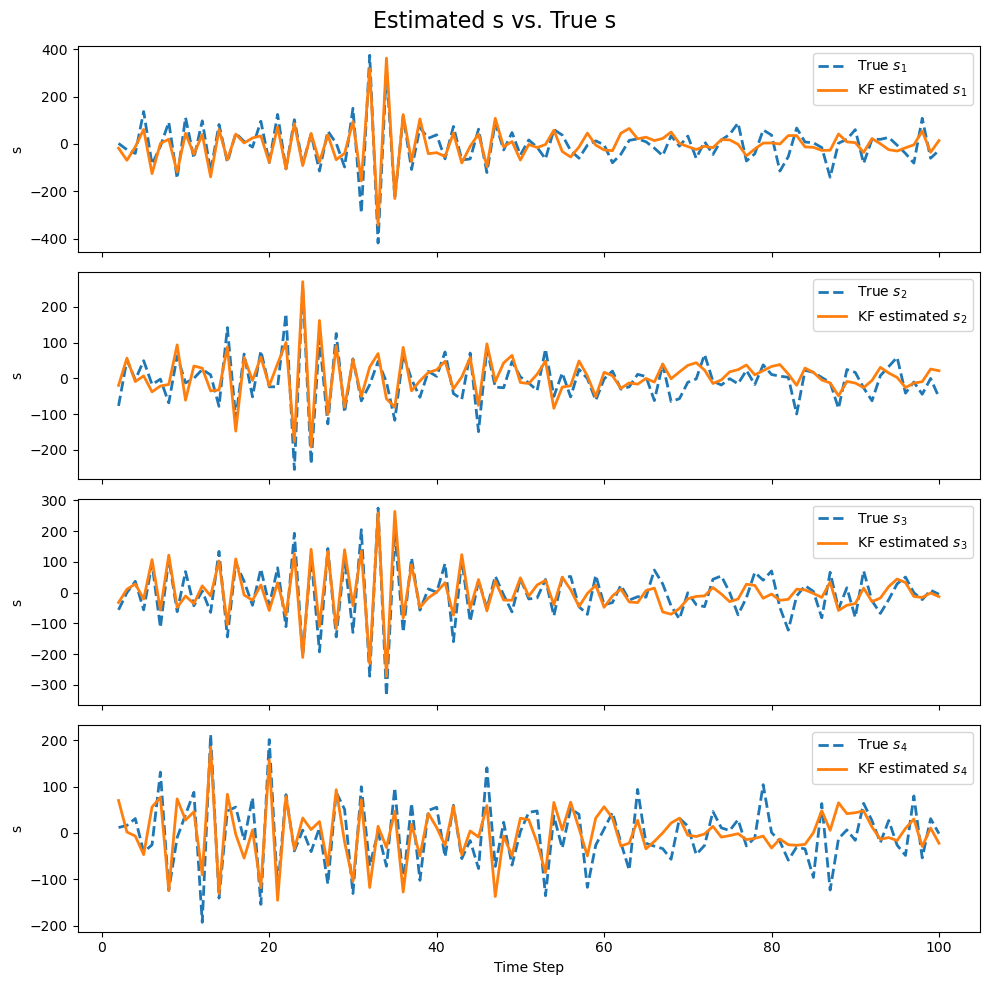

Metrics:

Player 1:
  Correlation = 0.89
  Std. Dev. of Error = 6.769638099632801

Player 2:
  Correlation = 0.872
  Std. Dev. of Error = 5.899915253628648

Player 3:
  Correlation = 0.911
  Std. Dev. of Error = 6.340110409133267

Player 4:
  Correlation = 0.798
  Std. Dev. of Error = 6.652067347825035



In [99]:
# S OPT VS S TRUE
# reconstruct optimal params
idx = 0
sigma_w = result.x[idx] if optimize_flags["sigma_w"] else 1e-2
idx += int(optimize_flags["sigma_w"])

sigma_v = result.x[idx] if optimize_flags["sigma_v"] else 50.0
Sigma_v = np.diag([sigma_v] * K)
idx += int(optimize_flags["sigma_v"])

sigma_alpha = result.x[idx] if optimize_flags["sigma_alpha"] else 0.3
Sigma_alpha = np.diag([sigma_alpha] * n_alpha)
idx += int(optimize_flags["sigma_alpha"])

alpha_KF_val = result.x[idx] if optimize_flags["alpha_KF_init"] else 1 / K
alpha_KF_init = np.array([alpha_KF_val] * n_alpha)

# run final KF; alpha_KF_predict & s_KF_predict
_, _, s_hat, _, alpha_hat, *_ = KF_ensemble(
    s=s_win,
    A=A,
    Sigma_v_init=Sigma_v,
    Sigma_w=sigma_w,
    alpha_KF_init=alpha_KF_init,
    Sigma_alpha_init=Sigma_alpha,
    w=w
)

# plot
fig, axs = plt.subplots(K, 1, figsize=(10, 2.5 * K), sharex=True)
fig.suptitle("Estimated s vs. True s", fontsize=16)

for i, player in enumerate(players):
    axs[i].plot(s_true[player], label=f"True $s_{{{player}}}$", linestyle='--', linewidth=2)
    axs[i].plot(s_hat[player], label=f"KF estimated $s_{{{player}}}$", linewidth=2)
    axs[i].legend()
    axs[i].set_ylabel("s")

axs[-1].set_xlabel("Time Step")
plt.tight_layout()
plt.show()

# METRICS
mets = metrics_ensemble(s_hat, s_true)
def print_mets(mets):
    print("Metrics:\n")
    for player, vals in mets.items():
        corr = vals['corr']
        std = np.sqrt(vals['std'])
        print(f"Player {player}:")
        print(f"  Correlation = {corr}")
        print(f"  Std. Dev. of Error = {std}")
        print()
print_mets(mets)

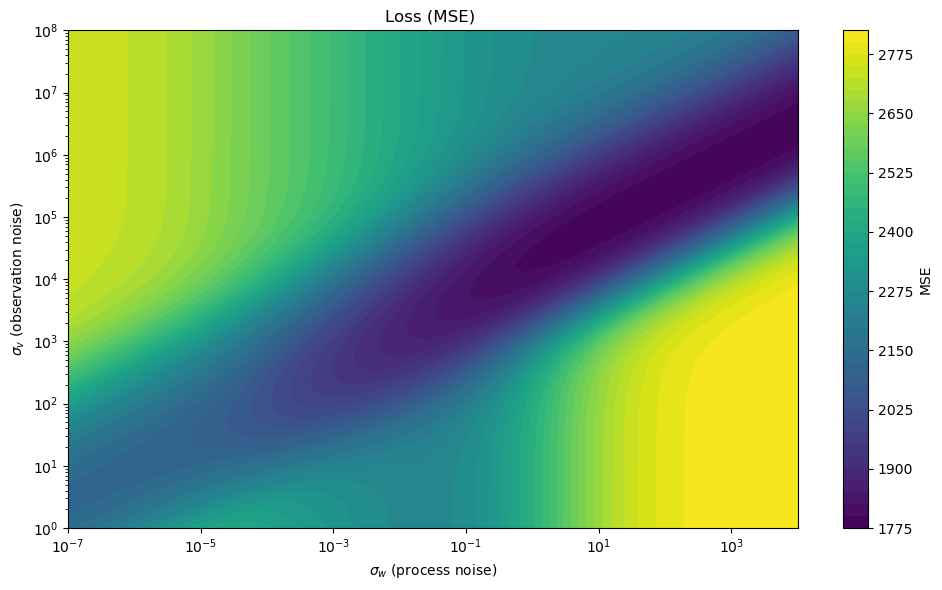

In [100]:
# HEATMAP
# grid for sigma_w and sigma_v
sigma_w_vals = np.logspace(-7, 4, 60)  # Log scale: 1e-7 to 1e4
sigma_v_vals = np.logspace(0, 8, 60)  # Log scale: 1 to 1e8
loss_surface = np.zeros((len(sigma_w_vals), len(sigma_v_vals)))

# fix other params
alpha_KF_val = 1 / K
alpha_KF_init = np.array([alpha_KF_val] * n_alpha)
Sigma_alpha = np.diag([0.3] * n_alpha)

# loss across grid
for i, sigma_w in enumerate(sigma_w_vals):
    for j, sigma_v in enumerate(sigma_v_vals):
        Sigma_v = np.diag([sigma_v] * K)
        try:
            _, _, s_hat, *_ = KF_ensemble(
                s=s_win,
                A=A,
                Sigma_v_init=Sigma_v,
                Sigma_w=sigma_w,
                alpha_KF_init=alpha_KF_init,
                Sigma_alpha_init=Sigma_alpha,
                w=w
            )

            s_hat_matrix = np.array([s_hat[p] for p in players])
            s_true_matrix = np.array([s_true[p] for p in players])
            valid_mask = ~np.isnan(s_hat_matrix) & ~np.isnan(s_true_matrix)

            if np.any(valid_mask):
                mse = np.mean((s_hat_matrix[valid_mask] - s_true_matrix[valid_mask]) ** 2)
                loss_surface[i, j] = mse
            else:
                loss_surface[i, j] = np.nan

        except Exception as e:
            loss_surface[i, j] = np.nan  # ignore failed runs

# plot heatmap
plt.figure(figsize=(10, 6))
contour = plt.contourf(sigma_w_vals, sigma_v_vals, loss_surface, levels=50, cmap="viridis")

plt.xscale('log')
plt.yscale('log')
plt.colorbar(contour, label="MSE")
plt.xlabel(r"$\sigma_w$ (process noise)")
plt.ylabel(r"$\sigma_v$ (observation noise)")
plt.title("Loss (MSE) ")
plt.tight_layout()
plt.show()

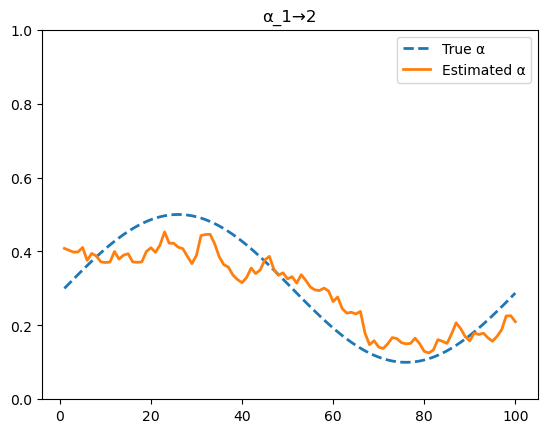

In [101]:
# ALPHA EST VS ALPHA TRUE
# plot alpha_true vs alpha_KF for specific player pairs
i = 1
j = 2

pair = f"{i}{j}"
alpha_true_vals = alpha[pair]
alpha_hat_vals = alpha_hat.get(pair, [np.nan] * (N + 1))


plt.plot(alpha_true_vals, label="True α", linestyle="--", linewidth=2)
plt.plot(alpha_hat_vals, label="Estimated α", linewidth=2)
plt.title(f"α_{i}→{j}")
plt.legend()
plt.ylim(0, 1)


plt.show()